In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition,preprocessing
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
import plotly.express as px
import pickle

# Data Loading

In [19]:
#df_data_all = pd.read_csv('rfm.csv').drop('customer_unique_id', axis=1)

In [20]:
df_data_all = pd.read_csv('rfm_final.csv')

In [132]:
df_data_all.shape

(96737, 8)

# Correlation - PCA

### PCA makes it possible to make a first reduction

In [3]:
#Standardardized
X_scaled = preprocessing.StandardScaler().fit_transform(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1))

In [134]:
# Compute of principal component
pca = decomposition.PCA(n_components=len(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1).columns),random_state=42)
X_projected = pca.fit_transform(X_scaled)

In [135]:
pd.DataFrame(X_projected).columns

RangeIndex(start=0, stop=6, step=1)

### Calculation of principal components

In [136]:
df_acp = pd.DataFrame()

In [137]:
for u in range(len(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1).columns)):
    df_acp["F"+str(u+1)] = pca.components_[u].tolist()

In [139]:
df_acp.set_axis(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1).columns, axis='index')

,F1,F2,F3,F4,F5,F6
R,0.138426,0.675288,-0.141114,-0.448911,-0.550795,-0.003829
F,0.269809,0.628267,0.090589,0.147737,0.695415,-0.137293
M,0.633621,-0.046536,-0.048850,0.277310,-0.116244,0.709619
MaxSpentbyCustomers,0.616804,-0.193368,-0.046663,0.214816,-0.240387,-0.689965
product_weightMeanbyCustomer,0.349001,-0.330728,-0.027991,-0.804785,0.345071,0.035787
MeanReviewScore,-0.065704,-0.018131,-0.983124,0.076986,0.150499,-0.015631


### Pareto Diagram - Scree plot

Text(0.5, 1.0, 'Diagramme de Pareto - Ebouli')

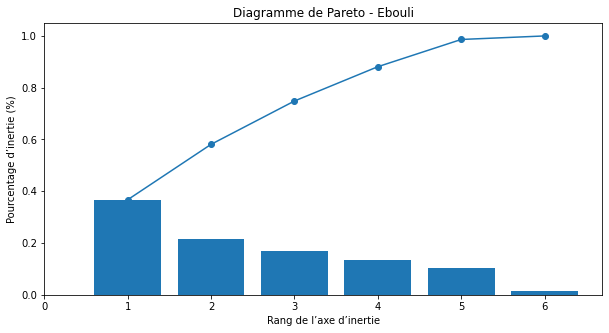

In [142]:
fig = plt.figure(figsize = (10, 5))
x = np.arange(1, len(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1).columns)+1, step=1) # add +1 because it starts at 1
y = pca.explained_variance_ratio_
#Affiche le bar chart
plt.bar(np.arange(1, len(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1).columns)+1, step=1),pca.explained_variance_ratio_)
#Affiche la courbe sommée
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xticks(np.arange(0, len(df_data_all.drop(['customer_unique_id','order_purchase_timestamp'], axis=1).columns)+1, step=1))
plt.ylabel('Pourcentage d’inertie (%)')
plt.xlabel('Rang de l’axe d’inertie')
plt.title('Diagramme de Pareto - Ebouli')

With Elbow method, we find thaht 70% of data can be explained with 2 components

In [143]:
np.cumsum(pca.explained_variance_ratio_)[2]

0.7485933788727099

Dial

(-0.7, 0.7)

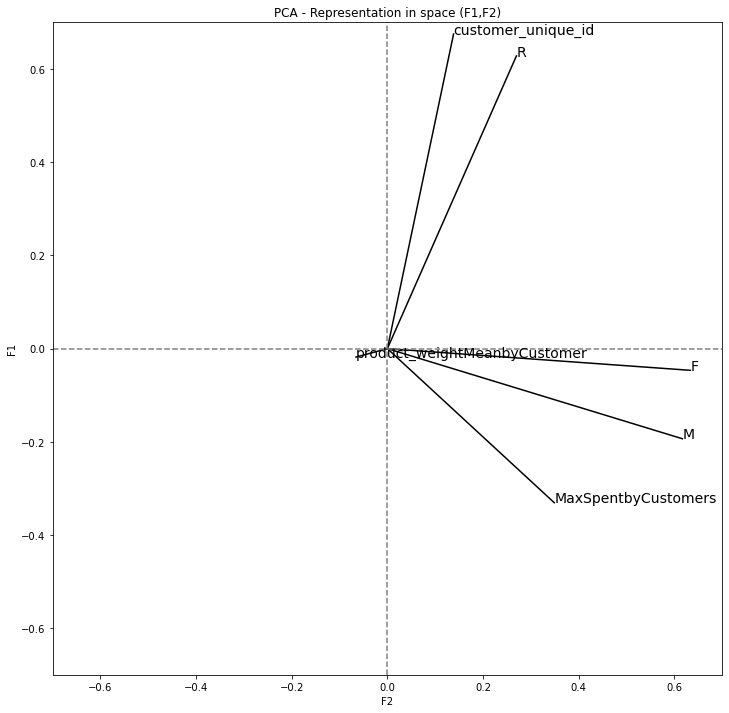

In [144]:
pcs = pca.components_

plt.figure(figsize=(12,12))
plt.xlabel('F2')
plt.ylabel('F1')
plt.title('PCA - Representation in space (F1,F2)')

#ax = plt.gca()
#ax.add_patch(plt.Circle((0,0), radius=1, color='black', fill=False, linestyle='-', clip_on=False)) #add the circle

#ax.set_xlim(-1,1)
#ax.set_ylim(-1,1)
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Display a segment from origin to the point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Display the name of the feature (df_data_all.columns[i])
    plt.text(x, y, df_data_all.columns[i], fontsize='14')

# Display an horizontal line y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Display vertical line x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
#plt.savefig('Cadran_Pca.png')

<AxesSubplot:title={'center':'PCA -Composante 1 et 2'}>

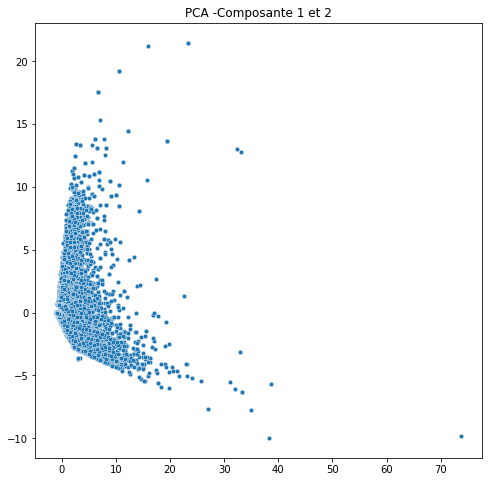

In [145]:
plt.figure(figsize=(8,8))
plt.title('PCA -Composante 1 et 2')
sns.scatterplot(x = X_projected[:,0],y = X_projected[:,1], s=20)

<AxesSubplot:title={'center':'PCA -Composante 1 et 3'}>

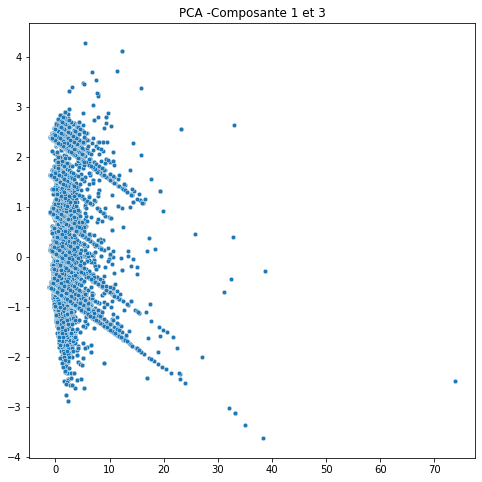

In [146]:
plt.figure(figsize=(8,8))
plt.title('PCA -Composante 1 et 3')
sns.scatterplot(x = X_projected[:,0],y = X_projected[:,2], s=20)

<AxesSubplot:title={'center':'PCA -Composante 2 et 3'}>

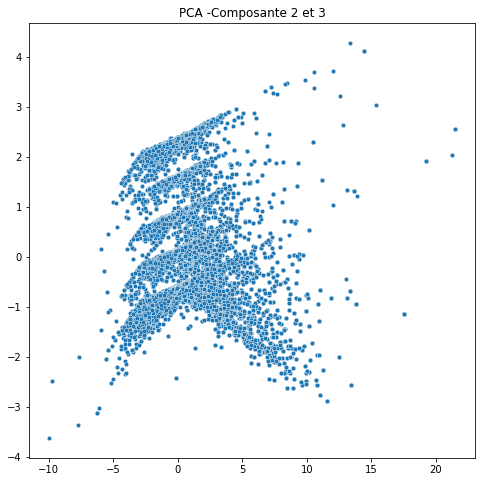

In [147]:
plt.figure(figsize=(8,8))
plt.title('PCA -Composante 2 et 3')
sns.scatterplot(x = X_projected[:,1],y = X_projected[:,2], s=20)

# T-SNE - nonlinear dimensionality reduction

In [21]:
#Standardardized
scaler_file = StandardScaler()
scaler_file.fit(df_data_all[['R','F','M']])
X_scaled = scaler_file.transform(df_data_all[['R','F','M']])
#X_scaled = preprocessing.StandardScaler().fit_transform(df_data_all[['R','F','M']])

In [22]:
X_scaled.shape

(96737, 3)

In [150]:
#tsne = TSNE(n_components=2,init='random',learning_rate='auto')

In [4]:
#X_tsne = tsne.fit_transform(X_scaled)
pickle_in = open("x_tsne_rfm.pkl","rb")
X_tsne=pickle.load(pickle_in)

In [152]:
#pickle_out = open("x_tsne_rfm.pkl","wb")
#pickle.dump(X_tsne,pickle_out)
#pickle_out.close()

In [153]:
X_tsne.shape

(96737, 2)

In [172]:
df_tsne = pd.DataFrame(X_tsne)
df_tsne.head()

,0,1
0,-24.452635,45.439842
1,-62.980534,-8.989278
2,-3.357976,57.938015
3,-133.963974,-34.440876
4,108.806015,36.728199


Text(0.5, 1.0, 'TSNE - Représentation des données')

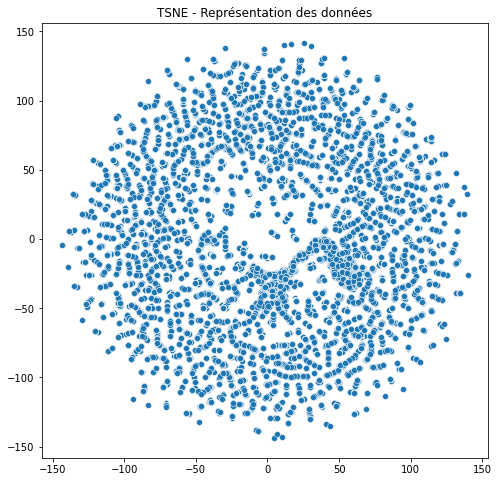

In [155]:
plt.figure(figsize=(8,8))
sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1])
plt.title('TSNE - Représentation des données')

# KMeans - Analysis

## KMeans - Elbow Method

In [156]:
Sum_of_squared_distances = []
K = range(1,18)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_scaled)
    Sum_of_squared_distances.append(km.inertia_)

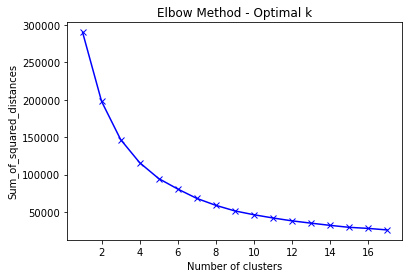

In [157]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method - Optimal k')
plt.show()

## Silhouette

In [158]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# I start at 2 clusters for silhouette coefficient
for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state = 42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

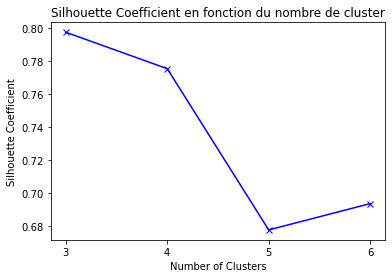

In [159]:
plt.plot(range(3, 7), silhouette_coefficients, 'bx-')
plt.xticks(range(3, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Coefficient en fonction du nombre de cluster')
plt.show()

In [23]:
nb_clusters = 4

# K means - Features : RFM

In [24]:
kmeans = KMeans(n_clusters=nb_clusters, max_iter=100, random_state = 42)
kmeans.fit(X_scaled)

KMeans(max_iter=100, n_clusters=4, random_state=42)

In [25]:
df_data_all['cluster'] = kmeans.labels_

## Clusters Analysis

<AxesSubplot:title={'center':'Distribution of client by cluster'}>

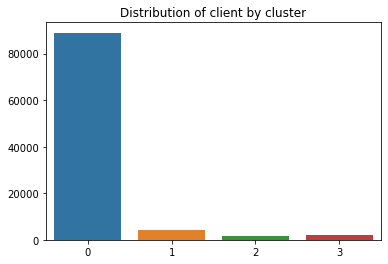

In [57]:
plt.title('Distribution of client by cluster')
sns.barplot(y = pd.Series(df_data_all['cluster']).value_counts().values,
           x = pd.Series(df_data_all['cluster']).value_counts().index)

Number of client by cluster

In [58]:
for i in range(0,4):
    print("Number of clients in cluster "+str(i)+" : "+str(len(df_data_all[df_data_all.cluster == i]['customer_unique_id'].unique())))

Number of clients in cluster 0 : 87591
Number of clients in cluster 1 : 3229
Number of clients in cluster 2 : 709
Number of clients in cluster 3 : 1886


Types of clients in each cluster

In [59]:
for i in range(0,4):
    print("Types of clients in cluster "+str(i)+" : \n"+str(df_data_all[df_data_all.cluster == i][['R','F','M']].mean()))

Types of clients in cluster 0 : 
R      0.833993
F      1.121652
M    117.992449
dtype: float64
Types of clients in cluster 1 : 
R     12.397870
F      4.136568
M    306.974360
dtype: float64
Types of clients in cluster 2 : 
R    264.062893
F      3.119497
M    304.781679
dtype: float64
Types of clients in cluster 3 : 
R       3.118687
F       1.469192
M    1314.145808
dtype: float64


Recency for all cluster

<AxesSubplot:title={'center':'Distribution of Recency by cluster'}, xlabel='cluster', ylabel='R'>

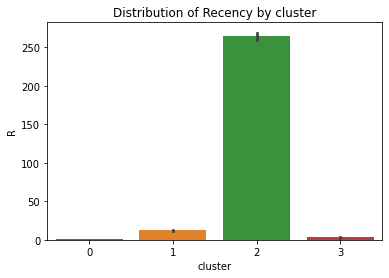

In [60]:
plt.title('Distribution of Recency by cluster')
sns.barplot(x = 'cluster', y = 'R', data = df_data_all)

Frequency for all clusters

<AxesSubplot:title={'center':'Distribution of Frequency by cluster'}, xlabel='cluster', ylabel='F'>

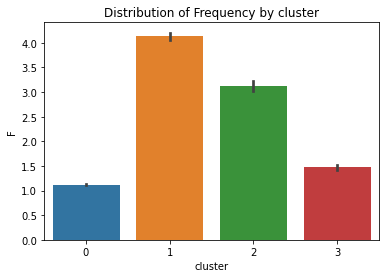

In [61]:
plt.title('Distribution of Frequency by cluster')
sns.barplot(x = 'cluster', y = 'F', data = df_data_all)

Monetary for all clusters

<AxesSubplot:title={'center':'Distribution of Monetary by cluster'}, xlabel='cluster', ylabel='M'>

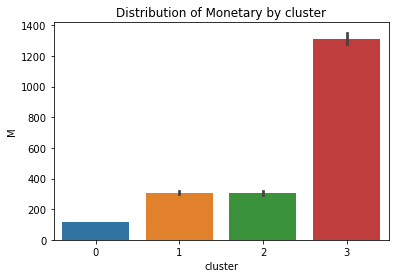

In [62]:
plt.title('Distribution of Monetary by cluster')
sns.barplot(x = 'cluster', y = 'M', data = df_data_all)

In [ ]:
Cluster 1 : client buy frequently than others
Cluster 2 : clients buy frequently and recently
Cluster 3 : clients spend more money than others
Cluster 0 : clients are the last in every categories

### Mean by cluster

In [8]:
clusterMean = df_data_all.groupby('cluster').agg({'R': lambda x: x.mean(),
'F': lambda x: x.mean(),
'M': lambda x: x.mean(),
'MeanReviewScore': lambda x : x.mean(), #Mean review score
}).reset_index()

In [10]:
clusterMean

,cluster,R,F,M,MeanReviewScore
0,0,0.833993,1.121652,117.992449,4.122647
1,1,12.397870,4.136568,306.974360,3.710669
2,2,264.062893,3.119497,304.781679,4.329771
3,3,3.118687,1.469192,1314.145808,4.006679


In [9]:
clusterMean.columns=['cluster','R','F','M','MeanReviewScore']

<AxesSubplot:title={'center':'Distribution of Recency by cluster'}, xlabel='cluster', ylabel='M'>

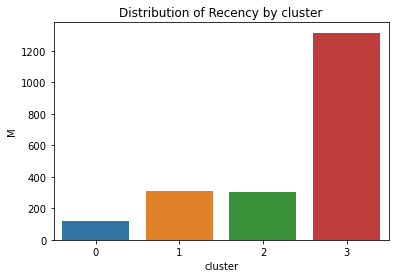

In [13]:
plt.title('Distribution of Recency by cluster')
sns.barplot(x = 'cluster', y = 'M', data = clusterMean)

## Boxplot

In [26]:
d_cluster0 = df_data_all[df_data_all['cluster']==0][['R','F','M']]
d_cluster1 = df_data_all[df_data_all['cluster']==1][['R','F','M']]
d_cluster2 = df_data_all[df_data_all['cluster']==2][['R','F','M']]
d_cluster3 = df_data_all[df_data_all['cluster']==3][['R','F','M']]

In [33]:
#fig = px.line_polar(d_cluster0, r='F', theta='M', line_close=True)
#fig.update_traces(fill='toself')
#fig.show()

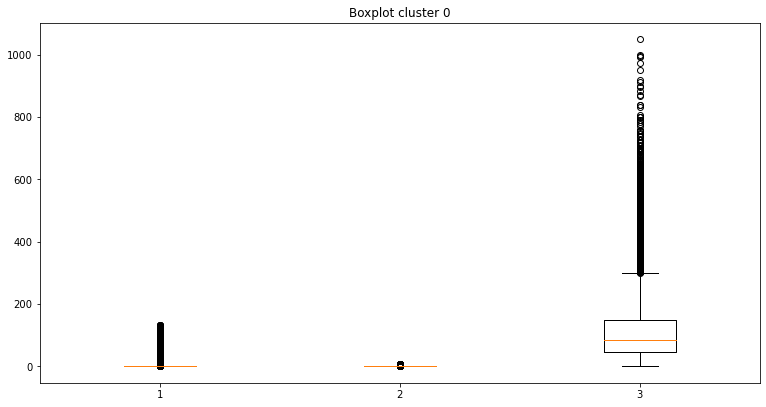

In [125]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster0)
plt.title('Boxplot cluster 0')
# show plot
plt.show()

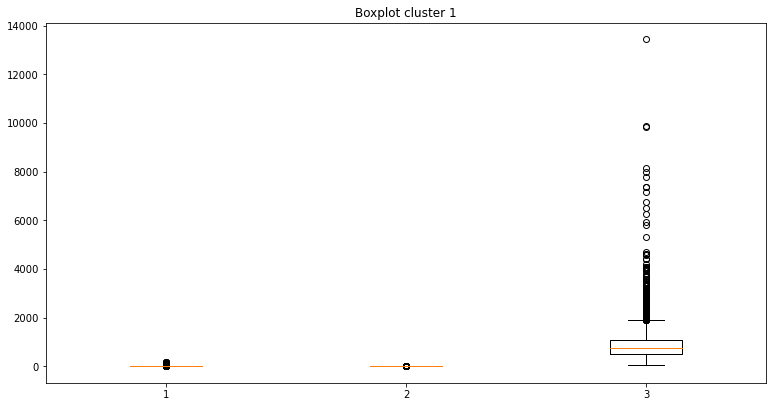

In [124]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster1)
plt.title('Boxplot cluster 1')
# show plot
plt.show()

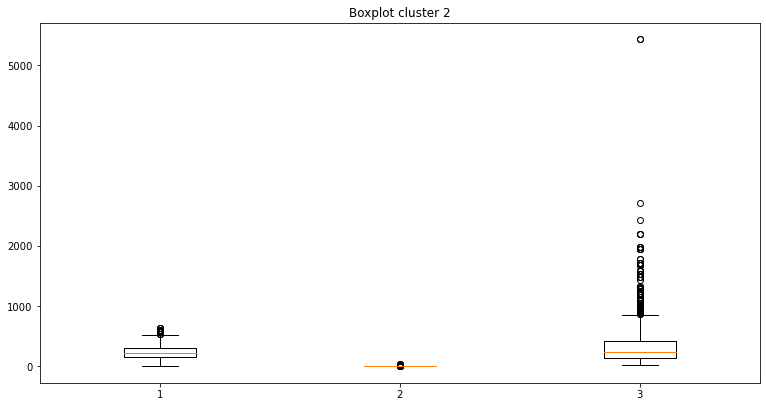

In [123]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster2)
plt.title('Boxplot cluster 2')
# show plot
plt.show()

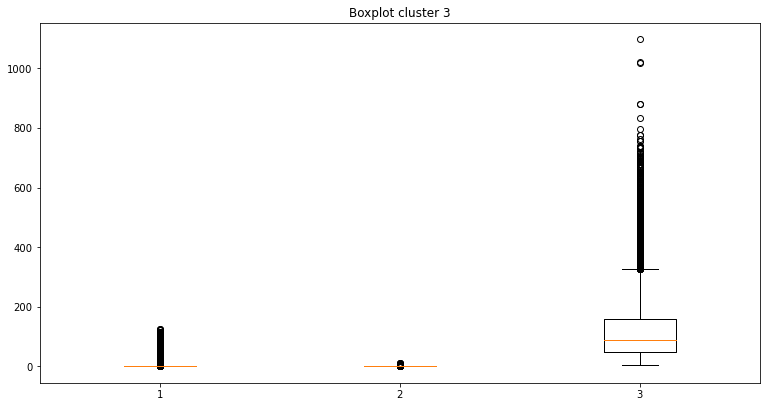

In [122]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster3)
plt.title('Boxplot cluster 3')
# show plot
plt.show()

## Scatter plot

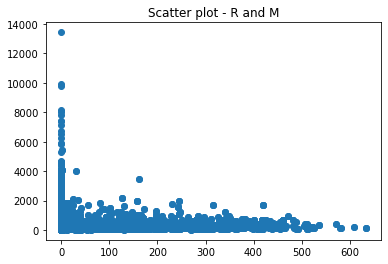

In [108]:
plt.title('Scatter plot - R and M')
plt.scatter(df_data_all[['R']], df_data_all[['M']])

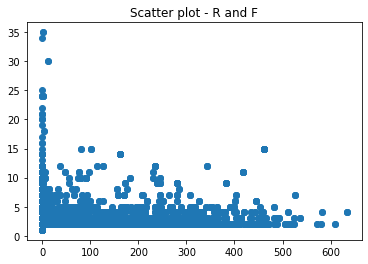

In [109]:
plt.title('Scatter plot - R and F')
plt.scatter(df_data_all[['R']], df_data_all[['F']])

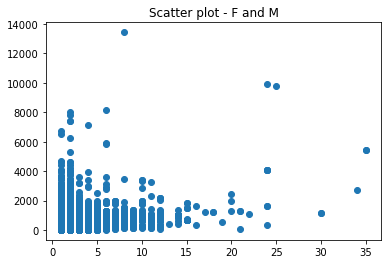

In [110]:
plt.title('Scatter plot - F and M')
plt.scatter(df_data_all[['F']], df_data_all[['M']])

## Chart - clusters

Text(0.5, 1.0, 'Clustering results - Customer Segmentation')

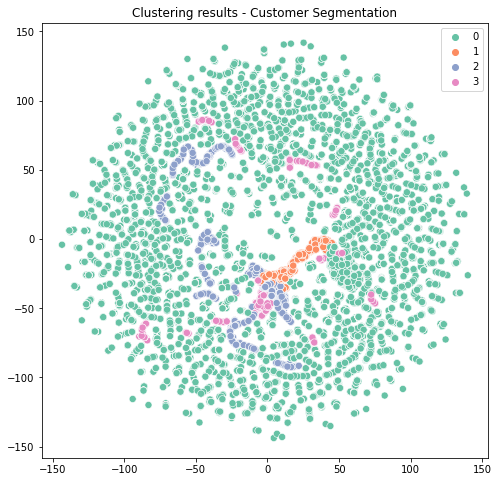

In [178]:
plt.figure(figsize=(8,8))

scat = sns.scatterplot(x = X_tsne[:,0],y = X_tsne[:,1],s=50,
                       data=df_tsne,
                       hue=kmeans.labels_,
                       style=3,
                       palette="Set2",)
scat.set_title("Clustering results - Customer Segmentation")

# KMeans - Features : Review Score

In [7]:
X_scaled_review = preprocessing.StandardScaler().fit_transform(df_data_all[['R','F','M','MeanReviewScore']])

In [180]:
Sum_of_squared_distances_review = []
K = range(1,15)
for k in K:
    km_review = KMeans(n_clusters=k)
    km_review = km_review.fit(X_scaled_review)
    Sum_of_squared_distances_review.append(km_review.inertia_)

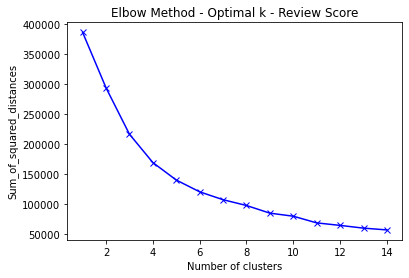

In [181]:
plt.plot(K, Sum_of_squared_distances_review, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method - Optimal k - Review Score')
plt.show()

In [25]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients_review = []

# I start at 2 clusters for silhouette coefficient
for k in range(3, 9):
    kmeans_review = KMeans(n_clusters=k, random_state = 42)
    kmeans_review.fit(X_scaled_review)
    score_review = silhouette_score(X_scaled_review, kmeans_review.labels_)
    silhouette_coefficients_review.append(score_review)

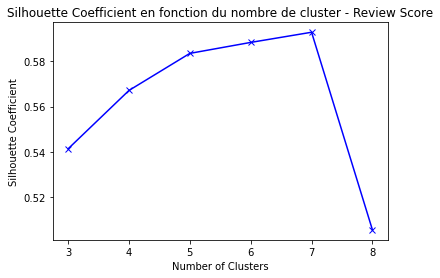

In [26]:
plt.plot(range(3, 9), silhouette_coefficients_review, 'bx-')
plt.xticks(range(3, 9))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Coefficient en fonction du nombre de cluster - Review Score')
plt.show()

Kmeans - R, F, M and MeanReviewScore

In [10]:
kmeans_review = KMeans(n_clusters=7, max_iter=100, random_state = 42)
kmeans_review.fit(X_scaled_review)

KMeans(max_iter=100, n_clusters=7, random_state=42)

In [11]:
df_data_all['cluster_review'] = kmeans_review.labels_

<AxesSubplot:title={'center':'Distribution of client by cluster'}>

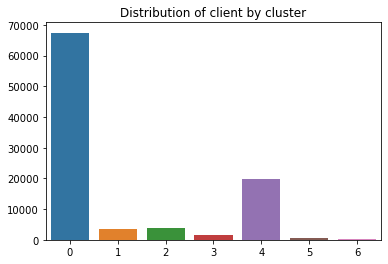

In [12]:
plt.title('Distribution of client by cluster')
sns.barplot(y = pd.Series(df_data_all['cluster_review']).value_counts().values,
           x = pd.Series(df_data_all['cluster_review']).value_counts().index)

In [13]:
for i in range(0,8):
    print("Number of clients in cluster "+str(i)+" : "+str(len(df_data_all[df_data_all.cluster_review == i]['customer_unique_id'].unique())))

Number of clients in cluster 0 : 66490
Number of clients in cluster 1 : 3519
Number of clients in cluster 2 : 2797
Number of clients in cluster 3 : 703
Number of clients in cluster 4 : 19346
Number of clients in cluster 5 : 443
Number of clients in cluster 6 : 117
Number of clients in cluster 7 : 0


The clusters 5, 6 and 7 have less than 500 clients, they will not be on our analysis

In [14]:
df_data_all_review = df_data_all.copy()

In [19]:
df_data_all_review = df_data_all_review[df_data_all_review['cluster_review']<=4]

<AxesSubplot:title={'center':'Distribution of Recency by cluster'}, xlabel='cluster_review', ylabel='R'>

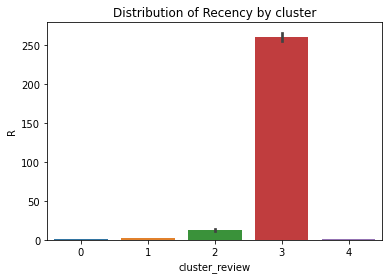

In [20]:
plt.title('Distribution of Recency by cluster')
sns.barplot(x = 'cluster_review', y = 'R', data = df_data_all_review)

<AxesSubplot:title={'center':'Distribution of Frequency by cluster'}, xlabel='cluster_review', ylabel='F'>

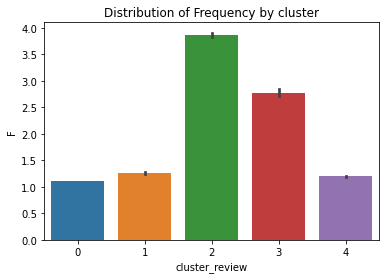

In [21]:
plt.title('Distribution of Frequency by cluster')
sns.barplot(x = 'cluster_review', y = 'F', data = df_data_all_review)

<AxesSubplot:title={'center':'Distribution of Monatery by cluster'}, xlabel='cluster_review', ylabel='M'>

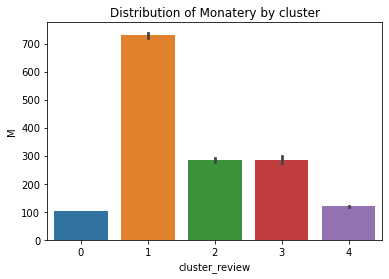

In [22]:
plt.title('Distribution of Monatery by cluster')
sns.barplot(x = 'cluster_review', y = 'M', data = df_data_all_review)

<AxesSubplot:title={'center':'Distribution of MeanReviewScore by cluster'}, xlabel='cluster_review', ylabel='MeanReviewScore'>

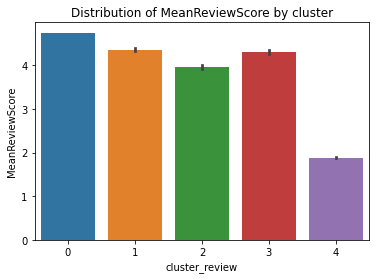

In [23]:
plt.title('Distribution of MeanReviewScore by cluster')
sns.barplot(x = 'cluster_review', y = 'MeanReviewScore', data = df_data_all_review)

In [72]:
d_cluster0_review = df_data_all_review[df_data_all_review['cluster_review']==0][['R','F','M','MeanReviewScore']]
d_cluster1_review = df_data_all_review[df_data_all_review['cluster_review']==1][['R','F','M','MeanReviewScore']]
d_cluster2_review = df_data_all_review[df_data_all_review['cluster_review']==2][['R','F','M','MeanReviewScore']]
d_cluster3_review = df_data_all_review[df_data_all_review['cluster_review']==3][['R','F','M','MeanReviewScore']]
d_cluster4_review = df_data_all_review[df_data_all_review['cluster_review']==4][['R','F','M','MeanReviewScore']]

## Scatter plot

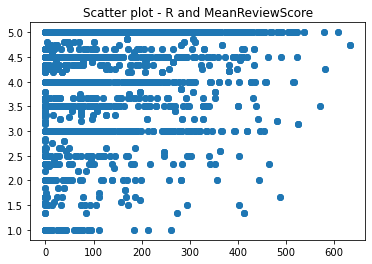

In [111]:
plt.title('Scatter plot - R and MeanReviewScore')
plt.scatter(df_data_all_review[['R']], df_data_all_review[['MeanReviewScore']])

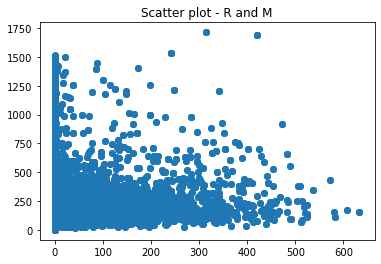

In [112]:
plt.title('Scatter plot - R and M')
plt.scatter(df_data_all_review[['R']], df_data_all_review[['M']])

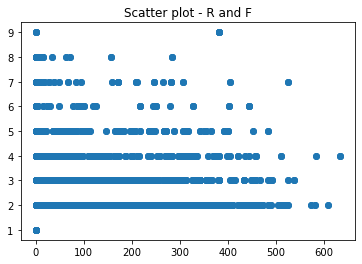

In [113]:
plt.title('Scatter plot - R and F')
plt.scatter(df_data_all_review[['R']], df_data_all_review[['F']])

## BoxPlot

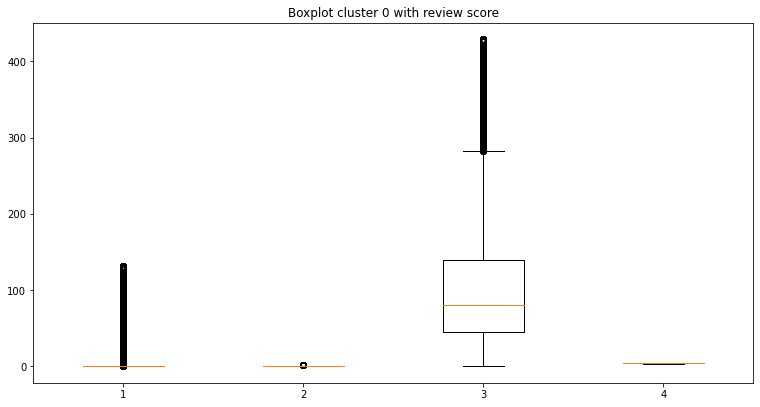

In [118]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster0_review)
plt.title('Boxplot cluster 0 with review score')
# show plot
plt.show()

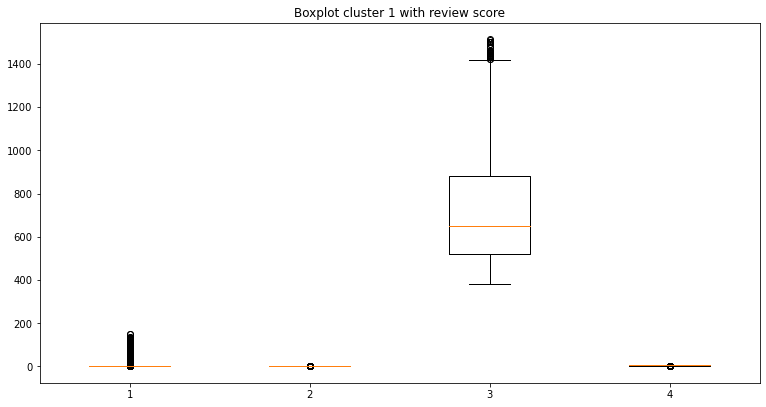

In [117]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster1_review)
plt.title('Boxplot cluster 1 with review score')
# show plot
plt.show()

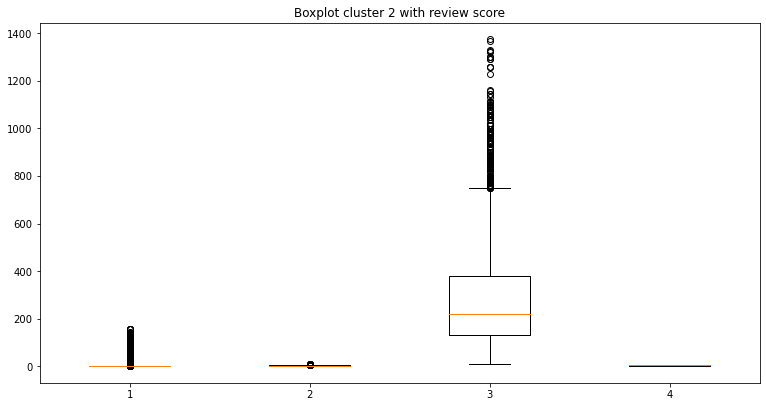

In [116]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster2_review)
plt.title('Boxplot cluster 2 with review score')
# show plot
plt.show()

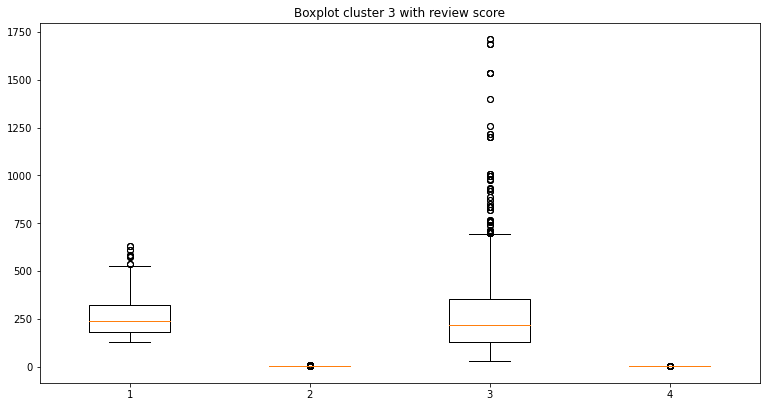

In [120]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster3_review)
plt.title('Boxplot cluster 3 with review score')
# show plot
plt.show()

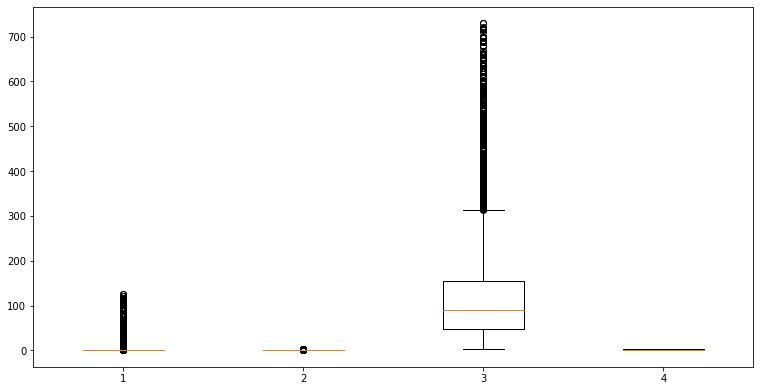

In [121]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d_cluster4)
# show plot
plt.show()

In [24]:
for i in range(0,5):
    print("Types of clients in cluster "+str(i)+" : \n"+str(df_data_all[df_data_all.cluster_review == i][['MeanReviewScore']].mean()))

Types of clients in cluster 0 : 
MeanReviewScore    4.746643
dtype: float64
Types of clients in cluster 1 : 
MeanReviewScore    4.365757
dtype: float64
Types of clients in cluster 2 : 
MeanReviewScore    3.957716
dtype: float64
Types of clients in cluster 3 : 
MeanReviewScore    4.315999
dtype: float64
Types of clients in cluster 4 : 
MeanReviewScore    1.880549
dtype: float64


## DBSCAN

We sample the Dataframe

In [3]:
df_sample = df_data_all[['R','F','M']].sample(frac=0.5)
df_sample.shape

(48368, 3)

We scale the sample

In [4]:
X_scaled_reduce = preprocessing.StandardScaler().fit_transform(df_sample)

In [5]:
db = DBSCAN(eps=1, min_samples=4,n_jobs=-1)
db.fit(X_scaled_reduce)

DBSCAN(eps=1, min_samples=4, n_jobs=-1)

In [10]:
tsne_reduce = TSNE(n_components=2,init='random',learning_rate='auto')
X_tsne_reduce = tsne_reduce.fit_transform(X_scaled_reduce)

/Users/nax/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'Clusters determined by DBSCAN')

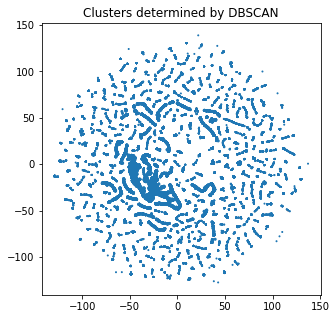

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(X_tsne_reduce[:,0], X_tsne_reduce[:,1],db.labels_)
plt.title("Clusters determined by DBSCAN")

## Agglomerative Clustering

In [ ]:
clustering = AgglomerativeClustering().fit(X_scaled_reduce)

In [21]:
df_sample['cluster_ag'] = clustering.labels_

the number of clusters found : 2

In [22]:
df_sample['cluster_ag'].nunique()

2

# Maintenance

We will analyze the stability of the model

In [4]:
df_data_maintenance = df_data_all

In [8]:
def new_file(data_frame, date_file1,date_file2):
    data_frame_file1 = data_frame[data_frame['order_purchase_timestamp']<date_file1]
    data_frame_file2 = data_frame[data_frame['order_purchase_timestamp']<date_file2]
    #listFile1 = data_frame_file1['customer_unique_id'].unique().tolist()
    #df_file1_step1 = data_frame_file1.sort_values(by=['order_purchase_timestamp']).drop_duplicates('customer_unique_id', keep='last')
    #df_file2_step1 = data_frame_file2[data_frame_file2['customer_unique_id'].isin(listFile1)]
    #df_file2_step2 = df_file2_step1.sort_values(by=['order_purchase_timestamp']).drop_duplicates('customer_unique_id', keep='last')
    #df_file2_final = df_file2_step2.drop(['customer_unique_id','order_purchase_timestamp'], axis=1)
    #df_file1_final = df_file1_step1.drop(['customer_unique_id','order_purchase_timestamp'], axis=1)
    return data_frame_file1,data_frame_file2

In [871]:
#listDate = ['2018-02-06','2018-03-06','2018-04-06','2018-05-06','2018-06-06','2018-07-06']

In [9]:
ARI_score = {}
listDate = ['2016-12-06','2017-01-06','2017-02-06','2017-03-06','2017-04-06','2017-05-06','2017-06-06','2017-07-06']
for i in listDate:
    df_file1, df_file2 = new_file(df_data_maintenance,'2016-11-06',i)
    scaler_file1 = StandardScaler()
    scaler_file2 = StandardScaler()
    scaler_file1.fit(df_file1[['R','F','M']])
    scaler_file2.fit(df_file2[['R','F','M']])
    X_scaled_file1 = scaler_file1.transform(df_file1[['R','F','M']])
    X_scaled_file2 = scaler_file2.transform(df_file2[['R','F','M']])
    kmeans_maintenance2 = KMeans(n_clusters=4,max_iter=100, random_state = 42)
    kmeans_maintenance2.fit(X_scaled_file2)
    kmeans_maintenance = KMeans(n_clusters=4,max_iter=100, random_state = 42)
    kmeans_maintenance.fit(X_scaled_file1)
    cluster_file1 = kmeans_maintenance.predict(X_scaled_file2)
    cluster_file2 = kmeans_maintenance2.predict(X_scaled_file2)
    ARI_score[i] = adjusted_rand_score(cluster_file1, cluster_file2)
    #ARI_score.append([i, adjusted_rand_score(cluster_file1, cluster_file2)])

Text(0.5, 1.0, 'ARI Score by date')

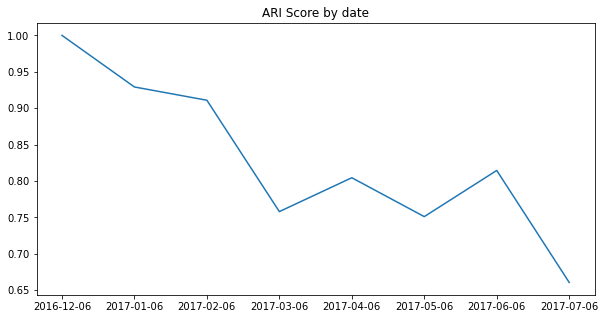

In [11]:
fig = plt.figure(figsize =(10, 5))
plt.plot(ARI_score.keys(), ARI_score.values())
plt.title("ARI Score by date")

Date de début : 2016-11-06

In [15]:
ARI_score

[['2016-12-06', 1.0],
 ['2017-01-06', 0.9291503238024069],
 ['2017-02-06', 0.9109162370340725],
 ['2017-03-06', 0.7580281932938724],
 ['2017-04-06', 0.8045132802254216],
 ['2017-05-06', 0.7511331804165707],
 ['2017-06-06', 0.8145333237864988],
 ['2017-07-06', 0.6607640345092515]]

Date de début : 2017-12-31

In [873]:
ARI_score

[['2018-02-06', 0.968279801763587],
 ['2018-03-06', 0.9680560584225832],
 ['2018-04-06', 0.9599245644497949],
 ['2018-05-06', 0.9430247623394756],
 ['2018-06-06', 0.9574289854775795],
 ['2018-07-06', 0.9557286181385656]]